In [306]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
learner_item_data = pd.read_csv('learner_item_data.csv')

In [145]:
learner_item_data['created_at'] = pd.to_datetime(learner_item_data['created_at'])
learner_item_data.head()

,uuid,created_at,trainer_item_id
0,6953977,2017-01-16 10:54:43.386,0
1,6953977,2017-01-16 10:56:25.717,1
2,6953977,2017-01-16 10:55:50.642,2
3,6953977,2017-01-16 10:54:19.796,3
4,6953977,2017-01-16 10:55:10.654,1


In [5]:
test_groups = pd.read_csv('test_groups.csv')

In [6]:
test_groups.head()

,test_group,uuid
0,control,6953977
1,test,1607983
2,control,6658627
3,control,4848596
4,test,1653336


## 1. Group User Sessions

In [68]:
# define treshold value as one hour
T = timedelta(seconds=3600)

# add a column containing previous timestamp
learner_item_data_sessions =  pd.concat([learner_item_data.sort_values(['uuid','created_at']),
                       learner_item_data.sort_values(['uuid','created_at']).groupby('uuid')['created_at'].transform(lambda x:x.shift(1))]
                      ,axis=1)
learner_item_data_sessions.columns = ['uuid','created_at', 'trainer_item_id','prev_created_at']

# create the new session column
learner_item_data_sessions['new_session'] = ((learner_item_data_sessions['created_at'] - learner_item_data_sessions['prev_created_at'])>T).astype(int)

# create the session_id
learner_item_data_sessions['increment'] = learner_item_data_sessions.sort_values(['uuid','created_at']).groupby("uuid")['new_session'].cumsum()
learner_item_data_sessions['session_id'] = learner_item_data_sessions['uuid'].astype(str) + '_' + learner_item_data_sessions['increment'].astype(str)

# sorting DF
learner_item_data_sessions = learner_item_data_sessions.sort_values(['uuid','created_at'])

## 2a. What is the distribution (histogram) of session lengths?

In [83]:
session_length = learner_item_data_sessions.groupby(['session_id'])['created_at'].max()-learner_item_data_sessions.groupby(['session_id'])['created_at'].min()

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Session Duration in Seconds')]

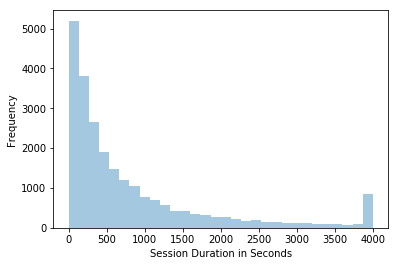

In [143]:
# due to a lot of rare values and a very skewed distribution with a long tail, I capped the bigger sessions than 4000
session_length_capped = np.where(session_length.dt.seconds > 4000, 4000, session_length.dt.seconds)
h = sns.distplot(session_length_capped, bins=30, kde=False)
h.set(xlabel='Session Duration in Seconds', ylabel='Frequency')

## 2b. How many people do several sessions a day? How many sessions? 

Assumptions: I'm accounting only for the days users logged in and did at least an item, so it's not the overall average, including all days since their sign up (which I don't have access to) but only the amount of users that when logged in, always do only one session or users that at least more than once, had different sessions in the same day.

In [147]:
learner_item_data_sessions['date'] = learner_item_data_sessions['created_at'].dt.date

In [162]:
total_sessions_per_user = learner_item_data_sessions.groupby(['uuid'])['session_id'].nunique()
total_days_per_user = learner_item_data_sessions.groupby(['uuid'])['date'].nunique()

In [168]:
avg_sessions_per_day = pd.DataFrame(total_sessions_per_user/total_days_per_user)

In [177]:
# number of people who at least for one day had more than one session
avg_sessions_per_day[avg_sessions_per_day[0]>1].count()[0]

850

In [178]:
# avg number of sessions for those who have more than one session per day
avg_sessions_per_day[avg_sessions_per_day[0]>1].mean()[0]

1.3624654135962855

# 3.

In [179]:
merged_df = learner_item_data_sessions.merge(test_groups, on='uuid')

In [182]:
merged_df.head()

,uuid,created_at,trainer_item_id,prev_created_at,new_session,increment,session_id,date,test_group
0,2990,2016-12-25 11:27:22.905,2,NaT,0,0,2990_0,2016-12-25,control
1,2990,2016-12-25 11:27:28.985,0,2016-12-25 11:27:22.905,0,0,2990_0,2016-12-25,control
2,2990,2016-12-25 11:27:33.603,3,2016-12-25 11:27:28.985,0,0,2990_0,2016-12-25,control
3,2990,2016-12-25 11:27:38.010,1,2016-12-25 11:27:33.603,0,0,2990_0,2016-12-25,control
4,2990,2016-12-28 09:40:57.271,604,2016-12-25 11:27:38.010,1,1,2990_1,2016-12-28,control


In [186]:
total_sessions_per_user = merged_df.groupby(['test_group','uuid'])['session_id'].nunique()
total_days_per_user = merged_df.groupby(['test_group','uuid'])['date'].nunique()

In [207]:
avg_sessions_per_day = pd.DataFrame(total_sessions_per_user/total_days_per_user).reset_index()

In [260]:
control_group_proportion = avg_sessions_per_day[(avg_sessions_per_day[0]>1) & (avg_sessions_per_day['test_group'] == 'control')]['uuid'].count()/avg_sessions_per_day[avg_sessions_per_day['test_group'] == 'control']['uuid'].count()


In [261]:
control_group_proportion

0.1132513344163379

In [258]:
test_group_proportion = avg_sessions_per_day[(avg_sessions_per_day[0]>1) & (avg_sessions_per_day['test_group'] == 'test')]['uuid'].count()/avg_sessions_per_day[avg_sessions_per_day['test_group'] == 'test']['uuid'].count()


In [259]:
test_group_proportion

0.11884438608010506

In [268]:
session_length_df = pd.DataFrame(session_length).reset_index()
session_length_df['uuid'] = session_length_df['session_id'].apply(lambda x: x.split('_')[0]).astype(int)
session_length_df = session_length_df.merge(test_groups, on='uuid')

In [269]:
session_length_df['session_length'] = session_length_df['created_at'].dt.seconds
session_length_df.groupby('test_group')['session_length'].median()

test_group
control    422
test       414
Name: session_length, dtype: int64

In [304]:
session_length_df.groupby('test_group').nunique()

,session_id,created_at,uuid,test_group,session_length
test_group,,,,,
control,14201,13832,4309,1,3102
test,9730,9479,3046,1,2672


## 3a. Is there a difference between the experiment groups in any of the two activity metrics?

In [295]:
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)  
    return p_value

In [299]:
# multiple sessions p-value
con_conv = 0.1132513344163379
test_conv = 0.11884438608010506
con_size = 4309
test_size = 3046
get_pvalue(con_conv,test_conv,con_size,test_size)

0.46148601597730854

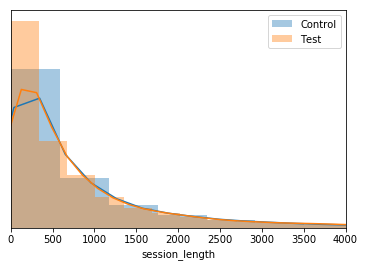

In [285]:
# comparison plot of the distributions of session length of both control and test group
fig, ax = plt.subplots()
sns.distplot(session_length_df[session_length_df['test_group']=='control']['session_length'], ax=ax, label='Control')
sns.distplot(session_length_df[session_length_df['test_group']=='test']['session_length'], ax=ax, label='Test')
ax.set_xlim([0, 4000])
ax.set_yticks([])
plt.legend()

In [305]:
# since we are using the median and the distribution is not normal, Mann Whitney U test 
# is a better choice of measurement for median time per session differences
from scipy.stats import mannwhitneyu

test = session_length_df[session_length_df['test_group']=='test']['created_at'].dt.seconds
control = session_length_df[session_length_df['test_group']=='control']['created_at'].dt.seconds
# compare samples
stat, p = mannwhitneyu(control, test)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=68928962.000, p=0.381
Same distribution (fail to reject H0)


## 3b. If there is a difference, how big is it?

There is no statistical significant difference between both groups averages on both sessions and users statistics.

## 3c. What would you recommend the Product Manager to do next?

I'd recommend him to not make the change since there's no proven benefit in either statistics we tracked so unless there's any other metric of business relevance, he should try another iteration.